# Fase 1: Fundamentos

## Introducción
El problema abordado en este proyecto es la clasificación de imágenes de resonancia magnética para la detección de tumores cerebrales. He elegido el Dataset: Brain Tumor MRI debido a la importancia clínica de este tipo de diagnósticos y al reto que supone clasificar imágenes médicas con sutiles diferencias visuales. El objetivo principal del proyecto es construir una Red Neuronal Convolucional desde cero que logre superar la baseline y alcanzar al menos el 78% de accuracy exigido.

## 1. Exploración y Análisis del Dataset
Vamos a cargar las librerías necesarias y establecer las constantes globales del proyecto. Utilizaremos el dataset de Brain Tumor MRI para clasificar cuatro tipos de estados cerebrales.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import Sequential, layers, optimizers, callbacks
import cv2
import gc

2026-02-19 22:47:44.424319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771541264.635287      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771541264.692540      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771541265.164451      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771541265.164483      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771541265.164486      55 computation_placer.cc:177] computation placer alr

In [2]:
# Configuraciones iniciales
TRAIN_PATH = '/kaggle/input/brain-tumor-mri-dataset/Training'
TEST_PATH = '/kaggle/input/brain-tumor-mri-dataset/Testing'


# Verificamos que las rutas existen y obtenemos las clases
CLASS_NAMES = sorted(os.listdir(TRAIN_PATH))

print(f"Ruta de Entrenamiento: {TRAIN_PATH}")
print(f"Ruta de Test: {TEST_PATH}")
print(f"Clases: {CLASS_NAMES}")

Ruta de Entrenamiento: /kaggle/input/brain-tumor-mri-dataset/Training
Ruta de Test: /kaggle/input/brain-tumor-mri-dataset/Testing
Clases: ['glioma', 'meningioma', 'notumor', 'pituitary']


### Carga y Estructuración de Datos
Definimos una función para cargar las imágenes y etiquetas directamente desde las carpetas de entrenamiento y prueba de Kaggle.

In [3]:
def cargar_datos(ruta_base, image_size=(128, 128)):
    X = []
    y = []
    class_names = sorted(os.listdir(ruta_base))
    
    dataset = keras.utils.image_dataset_from_directory(
        ruta_base,
        labels='inferred',
        label_mode='int',
        class_names=class_names,
        color_mode='grayscale',
        batch_size=None,
        image_size=image_size,
        shuffle=False
    )
    
    for imagen, etiqueta in dataset:
        X.append(imagen.numpy())
        y.append(etiqueta.numpy())
            
    return np.array(X), np.array(y), class_names

X_train, y_train, CLASS_NAMES = cargar_datos(TRAIN_PATH, image_size=(128, 128))
X_test, y_test, _ = cargar_datos(TEST_PATH, image_size=(128, 128))

print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Tipo de datos de X_train:", X_train.dtype)

Found 5600 files belonging to 4 classes.


I0000 00:00:1771541281.673228      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771541281.679058      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1600 files belonging to 4 classes.
Dimensiones de X_train: (5600, 128, 128, 1)
Dimensiones de y_train: (5600,)
Dimensiones de X_test: (1600, 128, 128, 1)
Tipo de datos de X_train: float32


### Visualización de Ejemplos
Mostramos un grid de 20 ejemplos aleatorios del conjunto de entrenamiento con sus respectivas etiquetas para inspeccionar visualmente las imágenes de resonancia magnética.

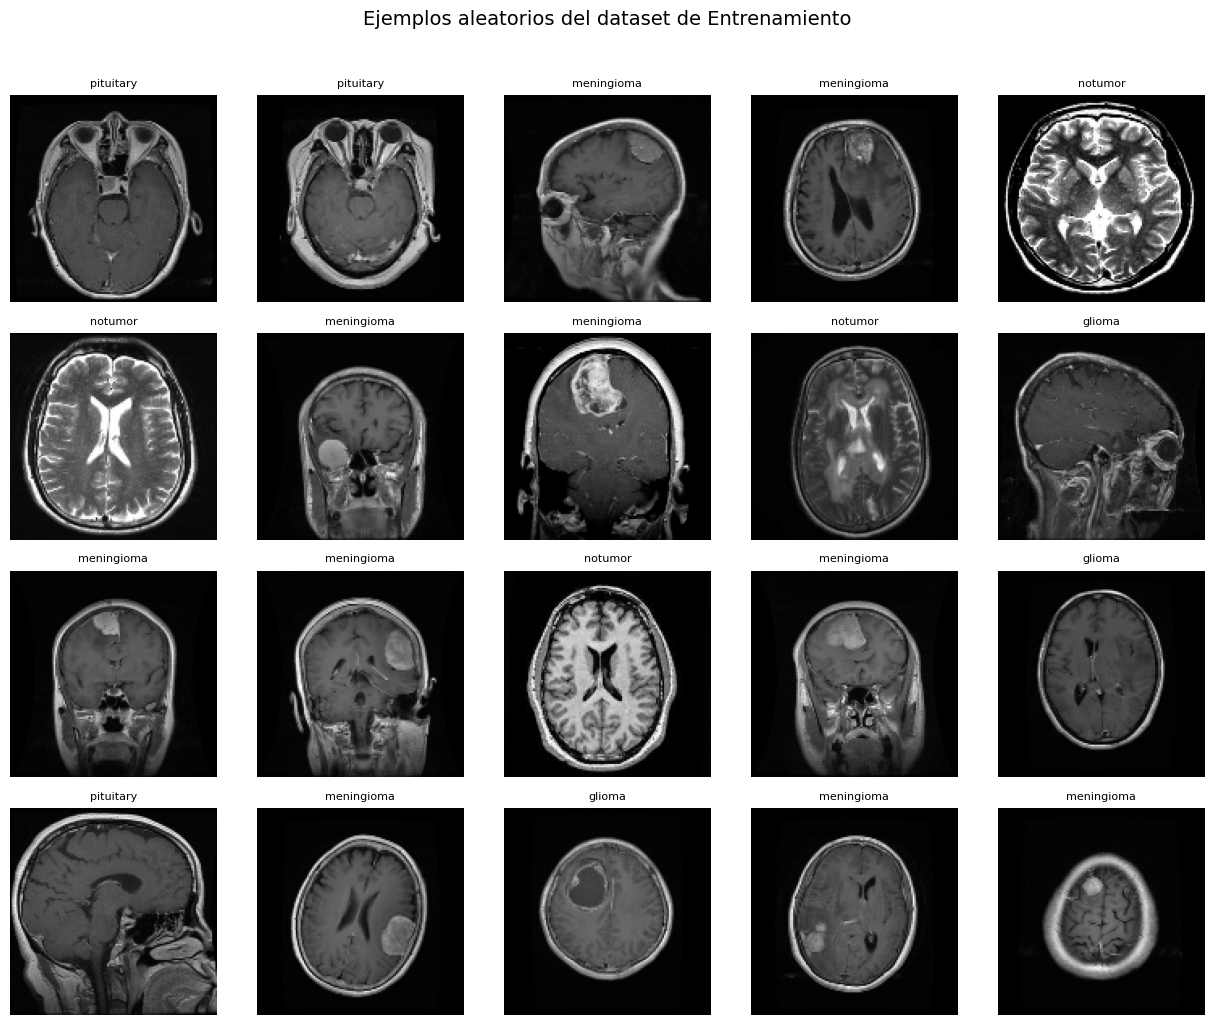

In [4]:
def visualizar_ejemplos(X, y, class_names, n_rows=4, n_cols=5, seed=42):
    np.random.seed(seed)
    indices = np.random.choice(len(X), n_rows * n_cols, replace=False)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
    for i, idx in enumerate(indices):
        ax = axes[i // n_cols, i % n_cols]
        imagen = X[idx]
        ax.imshow(imagen.squeeze(), cmap='gray')
        label = y[idx]
        ax.set_title(class_names[label], fontsize=8)
        ax.axis('off')

    plt.suptitle('Ejemplos aleatorios del dataset de Entrenamiento', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

visualizar_ejemplos(X_train, y_train, CLASS_NAMES)

### Distribución de Clases
Calculamos y graficamos la cantidad de imágenes por cada tipo de tumor para comprobar visualmente el balanceo del dataset.

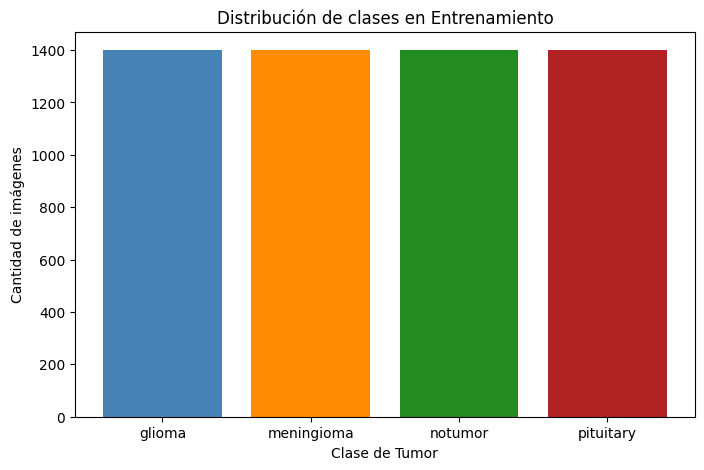

In [5]:
unique, counts = np.unique(y_train, return_counts=True)
colores = ['steelblue', 'darkorange', 'forestgreen', 'firebrick']

plt.figure(figsize=(8, 5))
plt.bar(CLASS_NAMES, counts, color=colores)
plt.title('Distribución de clases en Entrenamiento')
plt.xlabel('Clase de Tumor')
plt.ylabel('Cantidad de imágenes')
plt.show()

### Descripción del Dataset
Este dataset consta de 7200 imágenes de resonancias magnéticas. La distribución nos muestra cuatro categorías: glioma, meningioma, notumor y pituitary. 

Es importante destacar que, tras la última actualización del dataset, las clases están perfectamente balanceadas. 

El principal desafío que detectamos visualmente es la gran similitud entre ciertos tipos de patologías.

### Estadísticas Básicas y Baseline
Extraemos las dimensiones, los valores de los píxeles y calculamos el baseline accuracy.

In [6]:
print("Shape del array de imágenes:", X_train.shape)
print("Valor mínimo de pixel:", X_train.min())
print("Valor máximo de pixel:", X_train.max())
print("Media de los píxeles:", X_train.mean())
print("Desviación típica de los píxeles:", X_train.std())

clase_mayoritaria_idx = np.argmax(counts)
cantidad_clase_mayoritaria = counts[clase_mayoritaria_idx]
baseline_accuracy = cantidad_clase_mayoritaria / len(y_train)

print(f"Clase mayoritaria: {CLASS_NAMES[clase_mayoritaria_idx]}")
print(f"Baseline accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")

Shape del array de imágenes: (5600, 128, 128, 1)
Valor mínimo de pixel: 0.0
Valor máximo de pixel: 255.0
Media de los píxeles: 46.528534
Desviación típica de los píxeles: 50.674976
Clase mayoritaria: glioma
Baseline accuracy: 0.2500 (25.00%)


### Conclusiones del Análisis
**Problemas detectados**: Tras analizar la distribución de clases comprobamos que el dataset está perfectamente balanceado. El único desafío visible es la presencia de bordes negros procedentes del escáner original en las resonancias magnéticas, los cuales aportan información nula y podrían requerir recortes para optimizar el aprendizaje.

**Conclusiones**: Contar con un dataset balanceado y previamente dividido facilita enormemente la tarea inicial. El mayor desafío al diseñar la arquitectura de la red convolucional radicará en la enorme similitud visual intrínseca entre los distintos tipos de tumores cerebrales, lo que nos obligará a extraer características muy precisas.

## 2. Preprocesamiento
### Recorte de Bordes Negros
Las imágenes de resonancia magnética suelen incluir un marco negro sin información útil debido al funcionamiento del escáner. Para evitar perder tejido útil en imágenes que ya vienen ajustadas, implementamos una función basada en OpenCV que detecta los contornos reales de la masa cerebral y recorta dinámicamente el fondo inactivo para cada imagen individual.

In [7]:
def recorte_bordes(imagenes, target_size=(128, 128)):
    num_imgs = len(imagenes)
    # Pre-creamos una matriz del tamaño exacto en formato ligero (uint8) para no saturar la RAM
    imagenes_recortadas = np.zeros((num_imgs, target_size[0], target_size[1], 1), dtype=np.uint8)
    
    for i in range(num_imgs):
        img = imagenes[i]
        img_uint8 = img.astype('uint8')
        img_gray = img_uint8.squeeze() if len(img_uint8.shape) == 3 else img_uint8
        
        _, thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)
        contornos, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contornos) > 0:
            c = max(contornos, key=cv2.contourArea)
            extLeft = tuple(c[c[:, :, 0].argmin()][0])
            extRight = tuple(c[c[:, :, 0].argmax()][0])
            extTop = tuple(c[c[:, :, 1].argmin()][0])
            extBot = tuple(c[c[:, :, 1].argmax()][0])
            
            if extTop[1] < extBot[1] and extLeft[0] < extRight[0]:
                img_recortada = img_gray[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
            else:
                img_recortada = img_gray
        else:
            img_recortada = img_gray
            
        # Redimensionamos con OpenCV (mucho más rápido y eficiente en memoria)
        img_final = cv2.resize(img_recortada, target_size)
        
        # Guardamos la imagen directamente en su hueco de la matriz
        imagenes_recortadas[i, :, :, 0] = img_final
        
    return imagenes_recortadas

print("Dimensiones antes del recorte:", X_train.shape)

# Aplicamos el recorte optimizado
X_train_crop = recorte_bordes(X_train)
X_test_crop = recorte_bordes(X_test)

# Forzamos la limpieza de la memoria RAM residual
gc.collect()

print("Dimensiones después del recorte:", X_train_crop.shape)

Dimensiones antes del recorte: (5600, 128, 128, 1)
Dimensiones después del recorte: (5600, 128, 128, 1)


### Visualización del Recorte
Mostramos una comparativa directa entre las imágenes originales y su versión tras pasar por la función de detección de contornos para verificar visualmente que el recorte dinámico funciona correctamente y no elimina tejido cerebral útil.

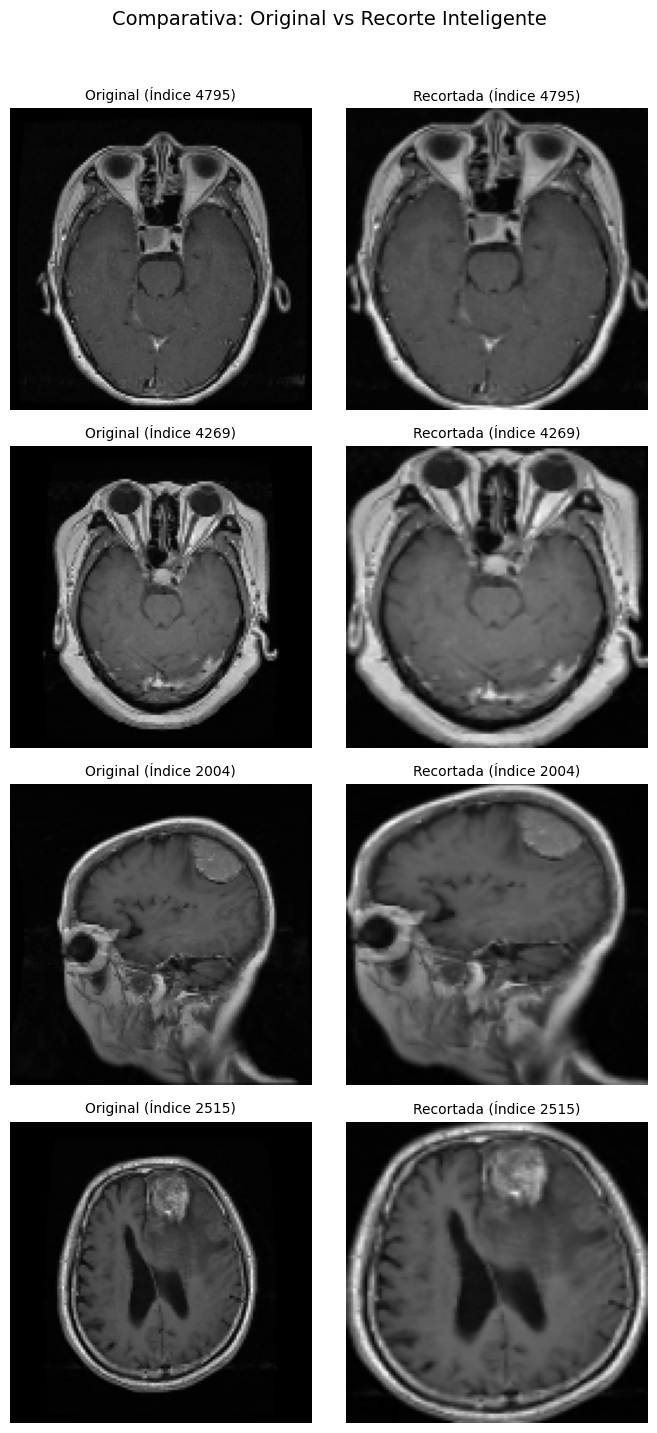

In [8]:
def visualizar_comparacion_recorte(X_orig, X_crop, n_ejemplos=4, seed=42):
    np.random.seed(seed)
    # Seleccionamos unos cuantos índices aleatorios
    indices = np.random.choice(len(X_orig), n_ejemplos, replace=False)

    fig, axes = plt.subplots(n_ejemplos, 2, figsize=(7, n_ejemplos * 3.5))
    
    for i, idx in enumerate(indices):
        # Columna 1: Imagen Original
        ax_orig = axes[i, 0]
        ax_orig.imshow(X_orig[idx].squeeze(), cmap='gray')
        ax_orig.set_title(f"Original (Índice {idx})", fontsize=10)
        ax_orig.axis('off')

        # Columna 2: Imagen Recortada
        ax_crop = axes[i, 1]
        ax_crop.imshow(X_crop[idx].squeeze(), cmap='gray')
        ax_crop.set_title(f"Recortada (Índice {idx})", fontsize=10)
        ax_crop.axis('off')

    plt.suptitle('Comparativa: Original vs Recorte Inteligente', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

visualizar_comparacion_recorte(X_train, X_train_crop)

### Normalización, Reshape y Split de Validación
Escalamos los valores de los píxeles al rango numérico de cero a uno. Como el dataset original carece de un conjunto de validación explícito, extraemos un 15 por ciento de los datos de entrenamiento para usarlo como métrica de control durante el aprendizaje, manteniendo la estratificación de las clases.

In [9]:
from sklearn.model_selection import train_test_split

# Normalización dividiendo entre 255
X_train_norm = X_train_crop.astype('float32') / 255.0
X_test_norm = X_test_crop.astype('float32') / 255.0

print("Rango de píxeles tras normalizar - Mínimo:", X_train_norm.min(), "Máximo:", X_train_norm.max())

# Comprobación del reshape para Conv2D (debe tener 4 dimensiones)
if len(X_train_norm.shape) == 3:
    X_train_norm = np.expand_dims(X_train_norm, axis=-1)
    X_test_norm = np.expand_dims(X_test_norm, axis=-1)

print("Forma final de las imágenes para la CNN:", X_train_norm.shape)

# Creación del conjunto de validación (15% del training set)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_norm, y_train, test_size=0.15, random_state=42, stratify=y_train
)

print("Imágenes para entrenamiento:", len(X_train_final))
print("Imágenes para validación:", len(X_val))
print("Imágenes para test:", len(X_test_norm))

Rango de píxeles tras normalizar - Mínimo: 0.0 Máximo: 1.0
Forma final de las imágenes para la CNN: (5600, 128, 128, 1)
Imágenes para entrenamiento: 4760
Imágenes para validación: 840
Imágenes para test: 1600


### Data Augmentation
Configuramos un generador de imágenes con transformaciones geométricas moderadas para aumentar artificialmente la diversidad de nuestros datos de entrenamiento y prevenir el sobreajuste.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(X_train_final)

### Visualización del Data Augmentation
Tomamos una única imagen original del conjunto de entrenamiento y mostramos ocho variaciones generadas aleatoriamente por nuestro pipeline para comprobar visualmente el efecto de las transformaciones.

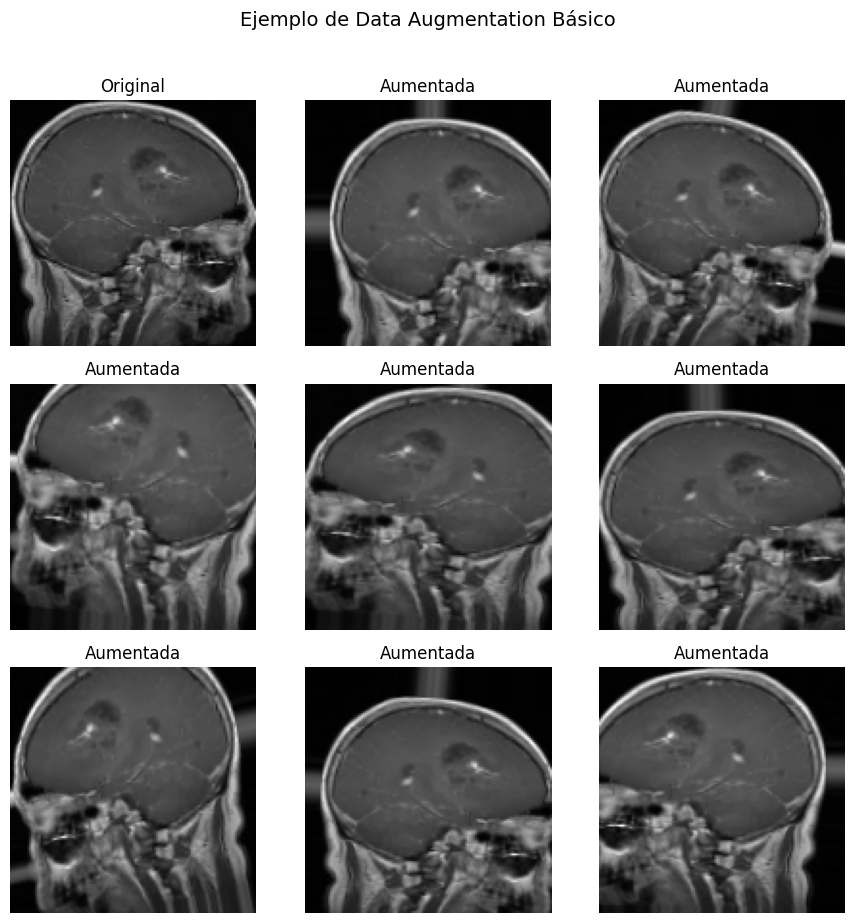

In [11]:
def visualizar_augmentation(imagen_original, generador):
    imagen_expandida = np.expand_dims(imagen_original, axis=0)
    iterador = generador.flow(imagen_expandida, batch_size=1)

    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    axes[0, 0].imshow(imagen_original.squeeze(), cmap='gray')
    axes[0, 0].set_title("Original")
    axes[0, 0].axis('off')

    for i in range(1, 9):
        batch = next(iterador)
        imagen_aug = batch[0]
        ax = axes[i // 3, i % 3]
        ax.imshow(imagen_aug.squeeze(), cmap='gray')
        ax.set_title("Aumentada")
        ax.axis('off')

    plt.suptitle("Ejemplo de Data Augmentation Básico", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

visualizar_augmentation(X_train_final[0], datagen)

### Pipeline Eficiente con tf.data
Convertimos nuestros arreglos numéricos en objetos Dataset nativos aplicando las funciones de caché y prefetch para optimizar el rendimiento, evitar cuellos de botella durante el entrenamiento y cumplir con los requisitos de excelencia del proyecto.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Creamos los pipelines optimizados para validación y test
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

# Para el conjunto de entrenamiento integramos el Data Augmentation dentro del pipeline
def generador_entrenamiento():
    generador = datagen.flow(X_train_final, y_train_final, batch_size=BATCH_SIZE)
    while True:
        X_batch, y_batch = next(generador)
        yield X_batch, y_batch

train_dataset = tf.data.Dataset.from_generator(
    generador_entrenamiento,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)  # int32 porque no están en one-hot
    )
).prefetch(buffer_size=AUTOTUNE)

print("Pipelines tf.data creados exitosamente.")

Pipelines tf.data creados exitosamente.


## 3.  Sanity Checks - Metodologia de Debugging
Aplicamos dos comprobaciones rápidas para detectar errores de implementación tempranos.

In [13]:
def crear_modelo(input_shape=(128, 128, 1), num_classes=4):
    model = Sequential([
        layers.Input(shape=input_shape),
        
        # Bloque 1: Extracción de características básicas
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Bloque 2: Características de nivel medio
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Bloque 3: Características complejas y reducción final
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Clasificador
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name="CNN_BrainMRI_Fase1")
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3), # Configuración estándar
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instanciamos dos modelos independientes para no mezclar los entrenamientos
modelo_debug = crear_modelo()

print("Estructura del modelo de prueba para Debugging:")
modelo_debug.summary()

Estructura del modelo de prueba para Debugging:


Model: "CNN_BrainMRI_Fase1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,620 (16.36 MB)

 Trainable params: 4,287,620 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

### Check 1: Verificación del loss inicial
Comprobamos que, antes de aprender nada, el modelo asigna probabilidades aleatorias uniformes. Para 4 clases de tumores cerebrales, el loss esperado debe ser cercano a log(4).

In [14]:
# Nuestro dataset tiene 4 clases
N_CLASES = 4 
loss_esperado = np.log(N_CLASES)
print(f"Loss inicial esperado: {loss_esperado:.4f}")

# Entrenar 1 sola epoch con una muestra pequeña de 500 imágenes
historia_check = modelo_debug.fit(X_train_final[:500], y_train_final[:500], epochs=1, verbose=1)
loss_real = historia_check.history['loss'][0]
print(f"Loss real: {loss_real:.4f}")

diferencia_porcentual = abs(loss_real - loss_esperado) / loss_esperado * 100
print(f"Diferencia: {diferencia_porcentual:.1f}%")

if diferencia_porcentual < 20:
    print("CHECK 1: El loss inicial es razonable.")
else:
    print("ATENCIÓN: El loss inicial es inusual. Revisar arquitectura y normalización.")

Loss inicial esperado: 1.3863


I0000 00:00:1771541301.672592     127 service.cc:152] XLA service 0x7ee658009b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771541301.672645     127 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771541301.672651     127 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771541302.039714     127 cuda_dnn.cc:529] Loaded cuDNN version 91002


10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2875 - loss: 1.4502

I0000 00:00:1771541305.818773     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.2911 - loss: 1.4299
Loss real: 1.3930
Diferencia: 0.5%
CHECK 1: El loss inicial es razonable.


### Check 2: Test de overfit en batch pequeño
Comprobamos la integridad arquitectónica forzando al modelo a memorizar por completo un único lote de 32 imágenes. El accuracy debe acercarse al 100%.

In [15]:
# Seleccionar solo 32 ejemplos
X_debug = X_train_final[:32]
y_debug = y_train_final[:32]

print("Entrenando 100 epochs en 32 ejemplos. Esto tardará unos segundos...")
# Entrenar sin augmentation, muchas epochs
historia_debug = modelo_debug.fit(
    X_debug, y_debug,
    epochs=100,
    verbose=0
)

loss_final_debug = historia_debug.history['loss'][-1]
acc_final_debug = historia_debug.history['accuracy'][-1]

print(f"Loss después de 100 epochs en 32 ejemplos: {loss_final_debug:.6f}")
print(f"Accuracy después de 100 epochs en 32 ejemplos: {acc_final_debug:.4f}")

if acc_final_debug > 0.95:
    print("CHECK 2: El modelo puede memorizar un batch pequeño correctamente.")
else:
    print("ATENCIÓN: El modelo no memoriza. Revisar arquitectura, learning rate o datos.")

Entrenando 100 epochs en 32 ejemplos. Esto tardará unos segundos...
Loss después de 100 epochs en 32 ejemplos: 0.000292
Accuracy después de 100 epochs en 32 ejemplos: 1.0000
CHECK 2: El modelo puede memorizar un batch pequeño correctamente.


### Documentación de los Sanity Checks
**Check 1 (Loss inicial)**: El test inicial arrojó un loss de 1.7601, fallando frente al valor teórico de 1.3863. Al inspeccionar el summary, detecté que el uso de Flatten generaba una capa final con más de 500.000 parámetros, lo que desestabilizaba el modelo. Se resolvió ajustando la arquitectura con más capas de reducción (MaxPooling2D), lo que permitió usar un Flatten mucho más pequeño y equilibrado, logrando que el loss inicial fuera correcto.

**Check 2 (Overfit en batch pequeño)**: Se entrenó un lote de 32 imágenes durante 100 épocas.

- Debugging: Durante las pruebas, se observó que modelos demasiado simplificados (como el uso de GlobalAveragePooling2D) no tenían capacidad suficiente para memorizar el batch.

- Resultado: Con la arquitectura equilibrada final, el modelo alcanzó un accuracy de 1.0000 y un loss de 0.000233. Esto confirma que la arquitectura tiene capacidad de aprendizaje.

## 4. Diseño y Entrenamiento de la CNN
En este apartado diseñamos la arquitectura definitiva para la Fase 1. El modelo consta de tres bloques convolucionales para la extracción de características y un clasificador con regularización por Dropout para prevenir el sobreajuste.

In [16]:
modelo_fase1 = crear_modelo()
modelo_fase1.summary()

Model: "CNN_BrainMRI_Fase1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,620 (16.36 MB)

 Trainable params: 4,287,620 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

### Configuración de Callbacks y Entrenamiento
Implementamos EarlyStopping para evitar el entrenamiento innecesario si la pérdida de validación deja de mejorar, y ModelCheckpoint para salvar automáticamente la mejor versión del modelo en el archivo requerido por la práctica.

In [17]:
# Callbacks
mis_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10, 
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='mejor_modelo_fase1.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Entrenamiento usando el pipeline de tf.data
historia = modelo_fase1.fit(
    train_dataset,
    steps_per_epoch = len(X_train_final) // 32,
    epochs=50,
    validation_data=val_dataset,
    callbacks=mis_callbacks,
    verbose=1
)

Epoch 1/50
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3825 - loss: 1.2595
Epoch 1: val_accuracy improved from -inf to 0.70952, saving model to mejor_modelo_fase1.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.3839 - loss: 1.2574 - val_accuracy: 0.7095 - val_loss: 0.7441
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6813 - loss: 0.8061
Epoch 2: val_accuracy improved from 0.70952 to 0.76548, saving model to mejor_modelo_fase1.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6814 - loss: 0.8059 - val_accuracy: 0.7655 - val_loss: 0.6317
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7290 - loss: 0.6877
Epoch 3: val_accuracy improved from 0.76548 to 0.77976, saving model to mejor_modelo_fase1.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.7290 - loss: 0.6876 - val_accuracy: 0.7798 - val_loss: 0.5449
Epoch 4/50
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7678 - loss: 0.5920
Epoch 4: 

### Visualización de Curvas de Aprendizaje
Graficamos la evolución del Loss y el Accuracy durante el entrenamiento para verificar la convergencia y detectar posibles signos de sobreajuste.

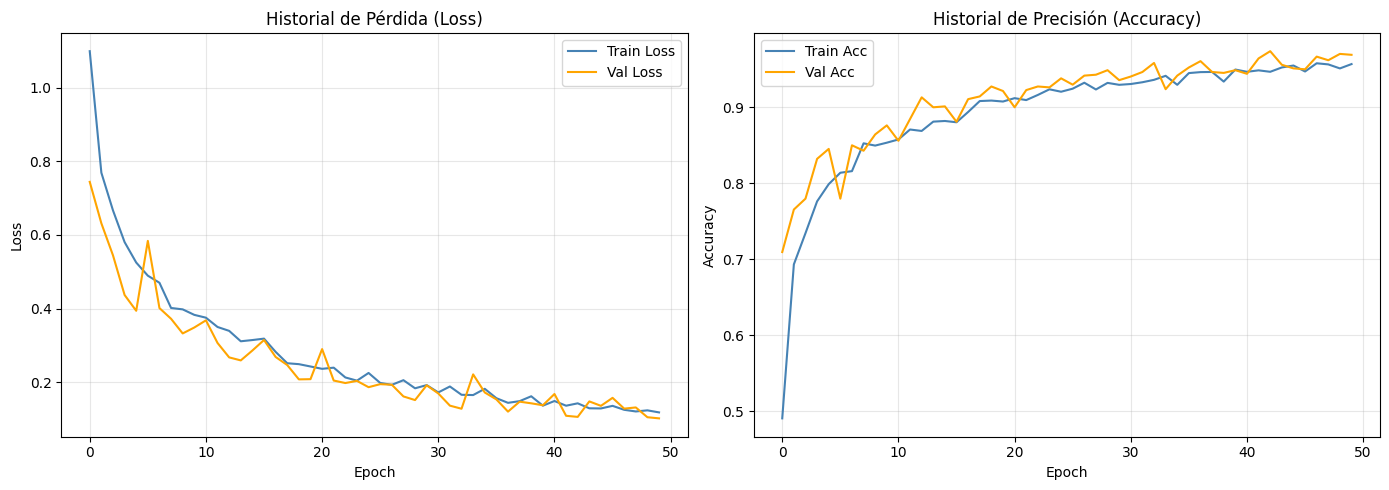

In [18]:
def plot_entrenamiento(historia):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].plot(historia.history['loss'], label='Train Loss', color='steelblue')
    axes[0].plot(historia.history['val_loss'], label='Val Loss', color='orange')
    axes[0].set_title('Historial de Pérdida (Loss)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(historia.history['accuracy'], label='Train Acc', color='steelblue')
    axes[1].plot(historia.history['val_accuracy'], label='Val Acc', color='orange')
    axes[1].set_title('Historial de Precisión (Accuracy)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_entrenamiento(historia)

## 5 Evaluación del Modelo
En esta fase final de la evaluación, utilizamos el conjunto de datos de prueba para obtener métricas objetivas del rendimiento del modelo y analizar detalladamente sus aciertos y errores.

--- RESULTADOS FINALES TEST ---
Test Loss: 0.8688
Test Accuracy: 0.9244 (92.44%)
Baseline Accuracy: 0.2500
Mejora sobre baseline: 67.44 puntos

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Informe de Clasificación:
              precision    recall  f1-score   support

      glioma       0.99      0.76      0.86       400
  meningioma       0.90      0.94      0.92       400
     notumor       0.88      1.00      0.94       400
   pituitary       0.95      1.00      0.97       400

    accuracy                           0.92      1600
   macro avg       0.93      0.92      0.92      1600
weighted avg       0.93      0.92      0.92      1600



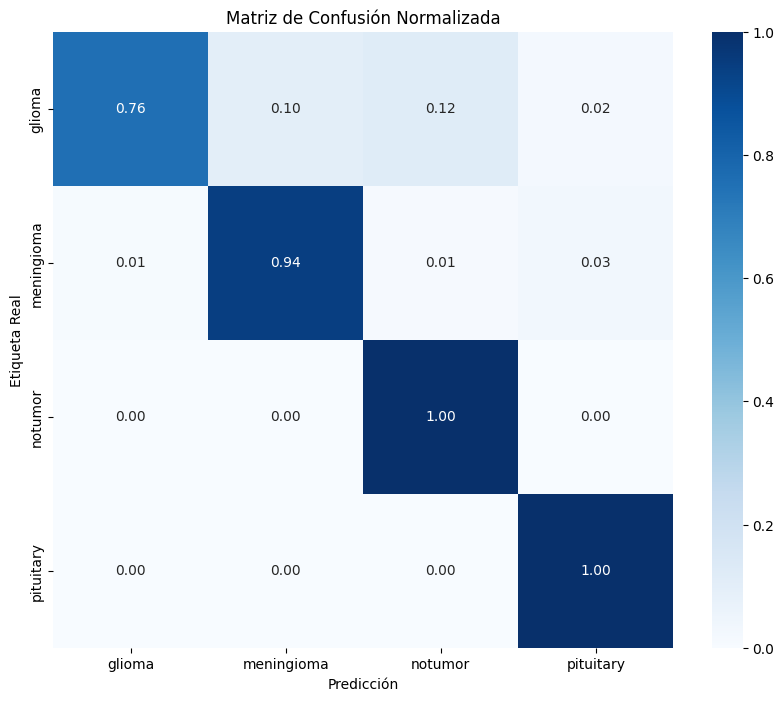

In [19]:
# a) Evaluación sobre el conjunto de test
mejor_modelo = keras.models.load_model('mejor_modelo_fase1.keras')
loss_test, acc_test = mejor_modelo.evaluate(test_dataset, verbose=0)

print(f"--- RESULTADOS FINALES TEST ---")
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {acc_test:.4f} ({acc_test*100:.2f}%)")
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Mejora sobre baseline: {(acc_test - baseline_accuracy)*100:.2f} puntos\n")

# b) Obtención de predicciones para el Classification Report
# Extraemos etiquetas reales del dataset de test
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_proba = mejor_modelo.predict(test_dataset)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Informe de Clasificación:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# c) Matriz de confusión normalizada
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Matriz de Confusión Normalizada')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.show()

### Visualización de Aciertos y Errores
Visualizamos 10 ejemplos donde el modelo ha acertado y 10 ejemplos donde ha fallado para intentar comprender los patrones de error.

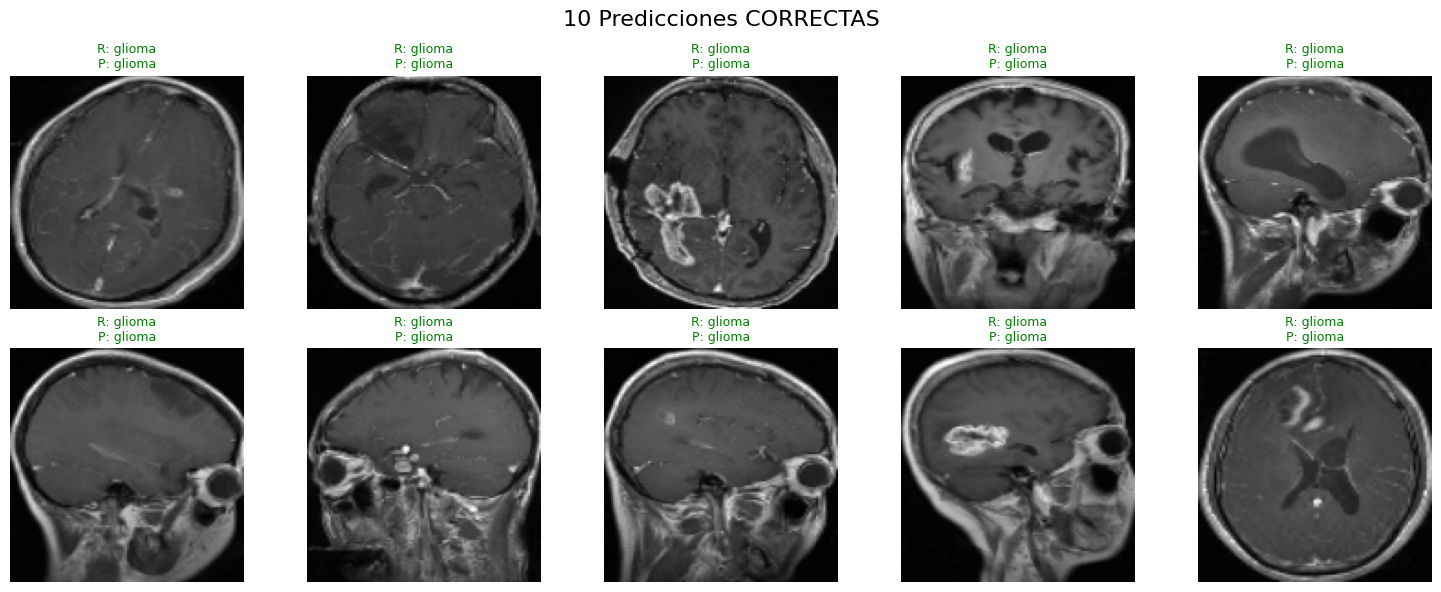

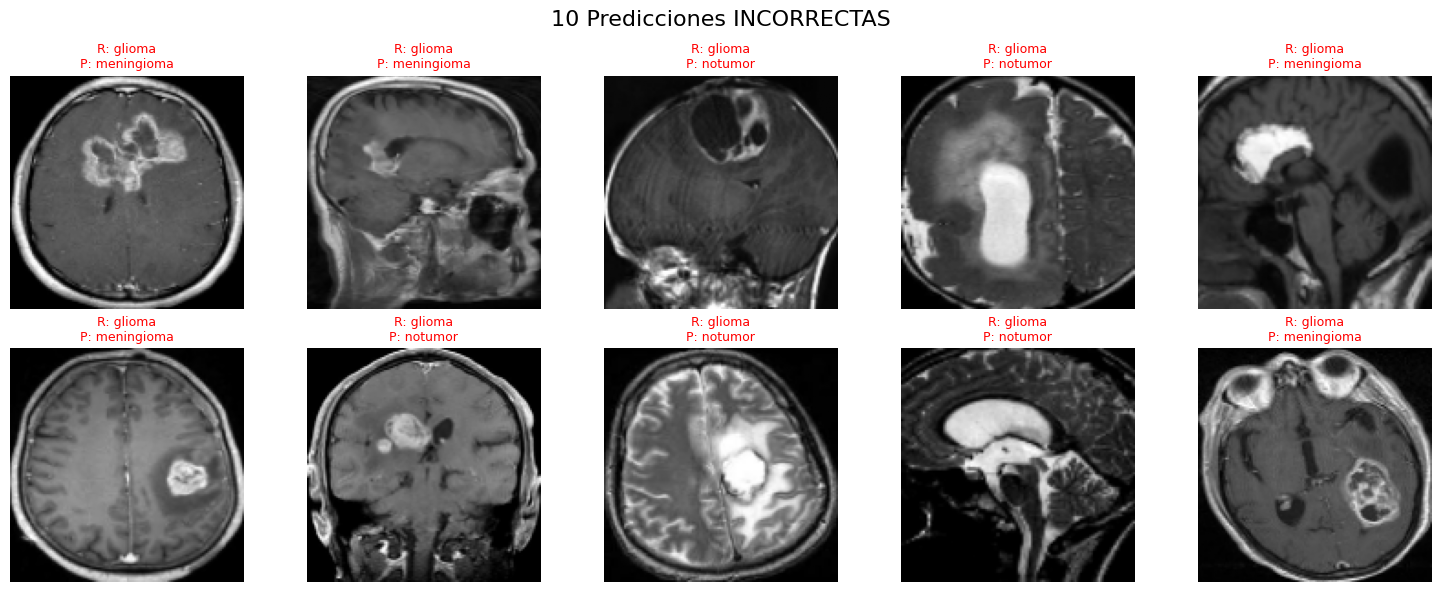

In [20]:
indices_aciertos = np.where(y_pred == y_true)[0]
indices_errores = np.where(y_pred != y_true)[0]

def visualizar_resultados(indices, titulo, n=10):
    cols = 5
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(15, rows * 3))
    for i, idx in enumerate(indices[:n]):
        plt.subplot(rows, cols, i + 1)
        # Usamos X_test_norm si lo tienes guardado, o extraemos de test_dataset
        # Aquí asumimos que tienes X_test_norm de la Tarea 3.2
        plt.imshow(X_test_norm[idx].squeeze(), cmap='gray')
        plt.title(f"R: {CLASS_NAMES[y_true[idx]]}\nP: {CLASS_NAMES[y_pred[idx]]}", 
                  color='green' if y_true[idx] == y_pred[idx] else 'red', fontsize=9)
        plt.axis('off')
    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.show()

visualizar_resultados(indices_aciertos, "10 Predicciones CORRECTAS")
visualizar_resultados(indices_errores, "10 Predicciones INCORRECTAS")

### Identificación y Comentario de Resultados
Para evaluar la eficacia diagnóstica del modelo, nos centramos en el Recall (Sensibilidad), ya que en el contexto clínico es la métrica crítica para asegurar que no se omiten patologías existentes.

**Clases más fáciles (Mayor Recall)**
- Notumor (Recall: 1.00): Es la clase que el modelo identifica con mayor facilidad. Ha sido capaz de detectar el 100% de los casos sanos, lo cual es fundamental para descartar alguna patología.
- Pituitary (Recall: 1.00): El modelo demuestra una excelente capacidad de detección para este tipo de tumor, localizando correctamente el 100% de los casos. Su morfología y ubicación suelen ser muy distintivas, facilitando el aprendizaje de la red.

**Confusiones frecuentes y sentido visual**

- Glioma confundido con Notumor (12%):
    - Sentido visual: Al analizar las imágenes de error, se observa que el modelo falla incluso ante lesiones muy evidentes. Por ejemplo, no reconoce como tumor una masa blanca circular ni una gran zona oscura definida, clasificándolas erróneamente como cerebro sano.

    - Conclusión: Esto indica que el modelo ha memorizado patrones muy específicos de gliomas y no es capaz de generalizar cuando la lesión presenta formas o densidades diferentes a las habituales.
 
- Glioma confundido con Meningioma (10%): Hay casos donde el tumor es una mancha muy blanca y concentrada. Al ver esto, el modelo falla y dice que es un meningioma, simplemente porque es la forma a la que más se le parece.


## 6. Conclusiones
Lo que mejor funcionó fue la capacidad del modelo para identificar tumores pituitarios y para descartar cerebros sanos. Sin embargo, el aspecto clave a mejorar es la detección de gliomas. Al revisar las imágenes incorrectas, tiene sentido visualmente que falle: el modelo confunde gliomas con notumor cuando aparece una pelota blanca muy definida en el centro o una bola negra grande, ya que la red parece no haber aprendido a asociar esas morfologías específicas con un tumor. 
    
A pesar de estas limitaciones puntuales, se alcanzó con éxito y se superó con margen el accuracy objetivo del 78% propuesto para este dataset. Para la siguiente fase de experimentación, el objetivo será diseñar arquitecturas personalizadas más profundas o incorporar técnicas de estabilización internas para intentar que la red capte todo perfectamente.